In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm
import torch

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood
from gpytorch.functions import log_normal_cdf
from gpytorch.utils.quadrature import GaussHermiteQuadrature1D

from pymc3.gp.util import plot_gp_dist

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
# Set seed
np.random.seed(123)

# Generate data

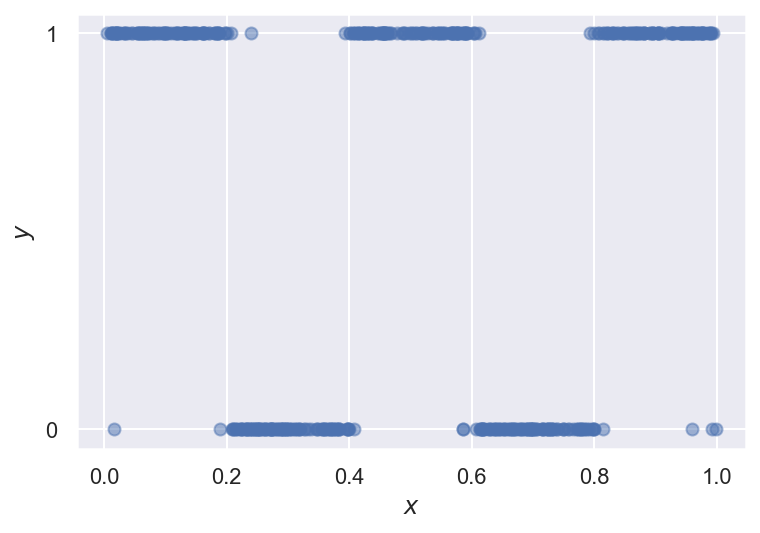

In [19]:
np.random.seed(0)

def true_f(x):
    return np.sin(10*x * np.pi * 0.5) * 10

n = 500
x = np.sort(np.random.uniform(0, 1, n))
f = true_f(x)
y = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

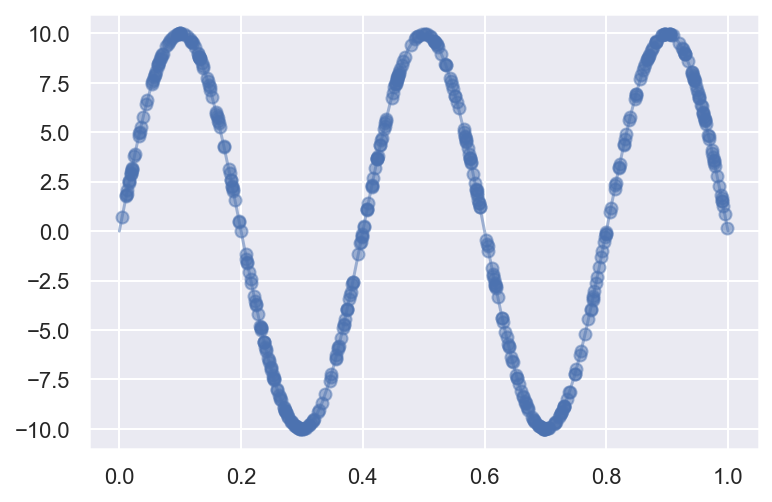

In [20]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5);

In [21]:
train_x = torch.from_numpy(x.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
print(train_x.dtype)
print(train_y.dtype)

torch.float32
torch.float32


In [22]:
inducing_points = torch.rand(50)

In [200]:
class CustomBernoulliLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Bernoulli likelihood used for GP classification, using
    Probit regression (i.e., the latent function is warped to be in [0,1]
    using the standard Normal CDF :math:`\Phi(x)`). Given the identity
    :math:`\Phi(-x) = 1-\Phi(x)`, we can write the likelihood compactly as:
    .. math::
        \begin{equation*}
            p(Y=y|f)=\Phi(yf)
        \end{equation*}
    """

    def forward(self, function_samples, **kwargs):
        raise NotImplementedError

    def log_marginal(self,  *args, **kwargs):
        raise NotImplementedError

    def marginal(self, function_dist, **kwargs):
        raise NotImplementedError

    def expected_log_prob(self, observations, function_dist, n_sample=40, *params, **kwargs):
    
        L = torch.linalg.cholesky(function_dist.covariance_matrix)
        m = function_dist.loc
        eta = torch.randn(torch.Size((observations.size(0), n_sample)))
        L_eta = L@eta
        f = m + L_eta.T 
        log_prob = torch.distributions.Bernoulli(logits=f).log_prob(observations).mean(axis=0)
        return log_prob
    
#         function_samples = function_dist.sample(torch.Size((5000,)))
#         log_prob = torch.distributions.Bernoulli(logits=function_samples).log_prob(observations).mean(axis=0)
#         return log_prob

#         observations = observations.mul(2).sub(1)
#         log_prob_lambda = lambda function_samples: log_normal_cdf(function_samples.mul(observations))
#         log_prob = self.quadrature(log_prob_lambda, function_dist)
#         return log_prob

In [201]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.quadrature = GaussHermiteQuadrature1D()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(inducing_points=inducing_points)
likelihood = CustomBernoulliLikelihood()

In [202]:
training_iter = 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())


iterator = tqdm(range(training_iter))

for i in iterator:
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

In [203]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)

In [204]:
pred = f_preds.sample(torch.Size((1000,))).numpy()

In [205]:
pred.shape

(1000, 101)

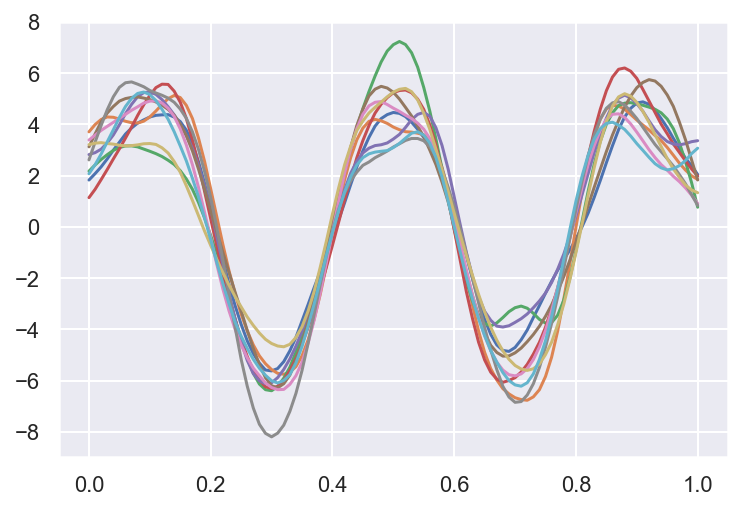

In [206]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(test_x, pred[i])

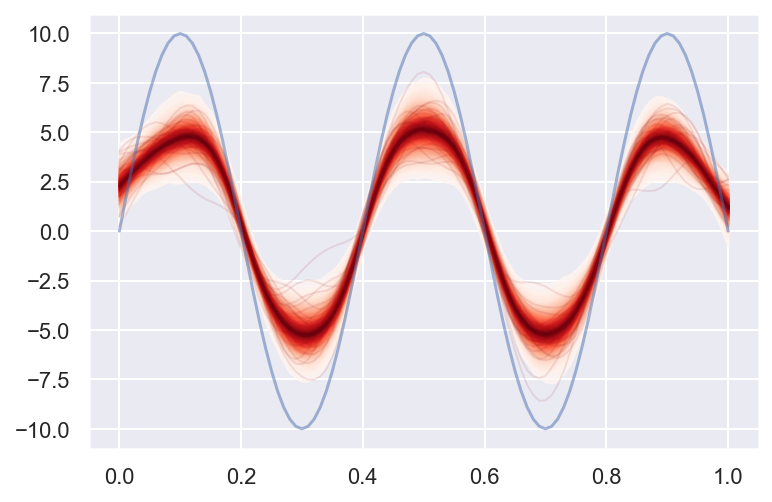

In [207]:
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, true_f(test_x), alpha=0.5)